In [ ]:
!pip install --upgrade derivative
!pip install scikit-learn==1.0.2
import os
os.kill(os.getpid(), 9)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 33.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
pip install pysindy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.9/120.9 KB 9.5 MB/s eta 0:00:00


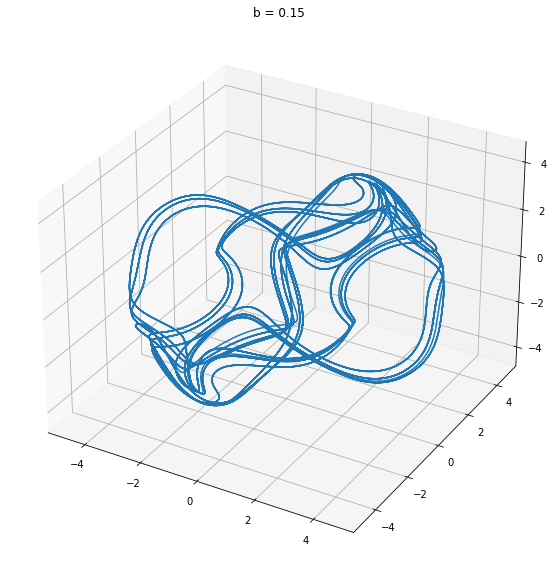

In [4]:
# Generate training data
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

b=0.15

def t_attr(state, t):
    x, y, z = state  # Unpack the state vector
    return  [np.sin(y) - b * x, np.sin(z) - b * y, np.sin(x) - b * z]  # Derivatives

dt = 0.01
t_train = np.arange(0, 1000, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [np.random.uniform(-3, 3),np.random.uniform(-3, 3),np.random.uniform(-3, 3)]
x_train = odeint(t_attr, x0_train, t_train)
x_dot_train_measured = np.array(
    [t_attr(x_train[i],0) for i in range(t_train.size)]
)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection="3d")
ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2])
plt.title("b = 0.15")
plt.draw()
plt.show()

In [5]:
# Fit the models and simulate
poly_order = 5
threshold = 0.05

noise_levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

models = []
t_sim = np.arange(0, 500, dt)
x_sim = []
for eps in noise_levels:
    model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=threshold),
        feature_library=ps.GeneralizedLibrary([ps.PolynomialLibrary(degree=poly_order),ps.FourierLibrary()]),
    )
    model.fit(
        x_train,
        t=dt,
        x_dot=x_dot_train_measured
        + np.random.normal(scale=eps, size=x_train.shape),
        quiet=True,
    )
    models.append(model)
    x_sim.append(model.simulate(x_train[0], t_sim))

In [6]:
print(models[0].equations())
print(models[1].equations())
print(models[2].equations())
print(models[3].equations())
print(models[4].equations())

['-0.150 x0 + 1.000 sin(1 x1)', '-0.150 x1 + 1.000 sin(1 x2)', '-0.150 x2 + 1.000 sin(1 x0)']
['-0.150 x0 + 1.000 sin(1 x1)', '-0.150 x1 + 1.000 sin(1 x2)', '-0.150 x2 + 1.000 sin(1 x0)']
['-0.150 x0 + 1.000 sin(1 x1)', '-0.150 x1 + 1.000 sin(1 x2)', '-0.150 x2 + 1.000 sin(1 x0)']
['-0.150 x0 + 1.000 sin(1 x1)', '-0.150 x1 + 1.000 sin(1 x2)', '-0.150 x2 + 1.000 sin(1 x0)']
['-0.150 x0 + 0.999 sin(1 x1)', '-0.150 x1 + 1.000 sin(1 x2)', '-0.150 x2 + 1.000 sin(1 x0)']


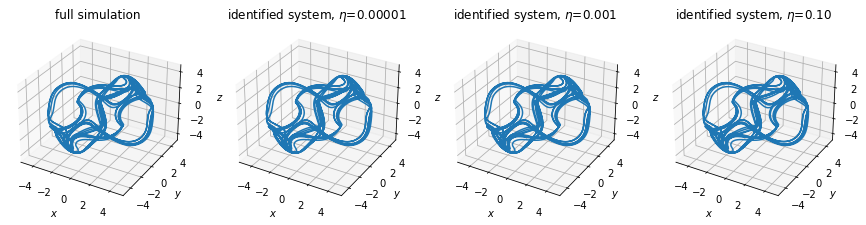

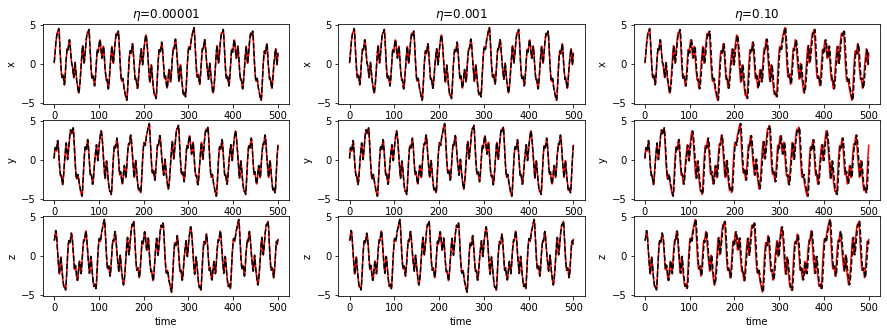

In [7]:
# Plot results

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(141, projection="3d")
ax.plot(
    x_train[: t_sim.size, 0],
    x_train[: t_sim.size, 1],
    x_train[: t_sim.size, 2],
)
plt.title("full simulation")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

model_idx = 0
ax = fig.add_subplot(142, projection="3d")
ax.plot(x_sim[model_idx][:, 0], x_sim[model_idx][:, 1], x_sim[model_idx][:, 2])
plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.5f}")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

model_idx = 2
ax = fig.add_subplot(143, projection="3d")
ax.plot(x_sim[model_idx][:, 0], x_sim[model_idx][:, 1], x_sim[model_idx][:, 2])
plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.3f}")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

model_idx = 4
ax = fig.add_subplot(144, projection="3d")
ax.plot(x_sim[model_idx][:, 0], x_sim[model_idx][:, 1], x_sim[model_idx][:, 2])
plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.2f}")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

fig = plt.figure(figsize=(15, 5))
model_idx = 0
ax = fig.add_subplot(331)
ax.plot(t_sim, x_train[: t_sim.size, 0], "r")
ax.plot(t_sim, x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.5f}")
plt.ylabel("x")

ax = fig.add_subplot(334)
ax.plot(t_sim, x_train[: t_sim.size, 1], "r")
ax.plot(t_sim, x_sim[model_idx][:, 1], "k--")
plt.xlabel("time")
plt.ylabel("y")

ax = fig.add_subplot(337)
ax.plot(t_sim, x_train[: t_sim.size, 2], "r")
ax.plot(t_sim, x_sim[model_idx][:, 2], "k--")
plt.xlabel("time")
plt.ylabel("z")

model_idx = 2
ax = fig.add_subplot(332)
ax.plot(t_sim, x_train[: t_sim.size, 0], "r")
ax.plot(t_sim, x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.3f}")
plt.ylabel("x")

ax = fig.add_subplot(335)
ax.plot(t_sim, x_train[: t_sim.size, 1], "r")
ax.plot(t_sim, x_sim[model_idx][:, 1], "k--")
plt.xlabel("time")
plt.ylabel("y")

ax = fig.add_subplot(338)
ax.plot(t_sim, x_train[: t_sim.size, 2], "r")
ax.plot(t_sim, x_sim[model_idx][:, 2], "k--")
plt.xlabel("time")
plt.ylabel("z")

model_idx = 4
ax = fig.add_subplot(333)
ax.plot(t_sim, x_train[: t_sim.size, 0], "r")
ax.plot(t_sim, x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.2f}")
plt.ylabel("x")

ax = fig.add_subplot(336)
ax.plot(t_sim, x_train[: t_sim.size, 1], "r")
ax.plot(t_sim, x_sim[model_idx][:, 1], "k--")
plt.xlabel("time")
plt.ylabel("y")

ax = fig.add_subplot(339)
ax.plot(t_sim, x_train[: t_sim.size, 2], "r")
ax.plot(t_sim, x_sim[model_idx][:, 2], "k--")
plt.xlabel("time")
plt.ylabel("z")

fig.show()

In [8]:
# Fit the models and simulate

noise_levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

models_noD = []
t_sim = np.arange(0, 500, dt)
x_sim_noD = []
for eps in noise_levels:
    model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=threshold),
        feature_library=ps.GeneralizedLibrary([ps.PolynomialLibrary(degree=poly_order),ps.FourierLibrary()]),
    )
    model.fit(x_train + np.random.normal(scale=eps, size=x_train.shape), 
              t=dt, quiet=True)
    models_noD.append(model)
    x_sim_noD.append(model.simulate(x_train[0], t_sim))

In [9]:
print(models_noD[0].equations())
print(models_noD[1].equations())
print(models_noD[2].equations())
print(models_noD[3].equations())
print(models_noD[4].equations())

['-0.150 x0 + 1.000 sin(1 x1)', '-0.150 x1 + 1.000 sin(1 x2)', '-0.150 x2 + 1.000 sin(1 x0)']
['-0.150 x0 + 1.000 sin(1 x1)', '-0.150 x1 + 1.000 sin(1 x2)', '-0.150 x2 + 1.000 sin(1 x0)']
['-0.150 x0 + 1.000 sin(1 x1)', '-0.150 x1 + 1.000 sin(1 x2)', '-0.150 x2 + 1.000 sin(1 x0)']
['-0.150 x0 + 1.000 sin(1 x1)', '-0.150 x1 + 1.000 sin(1 x2)', '-0.150 x2 + 1.000 sin(1 x0)']
['-0.148 x0 + 0.993 sin(1 x1)', '0.769 sin(1 x2)', '-0.148 x2 + 0.995 sin(1 x0)']


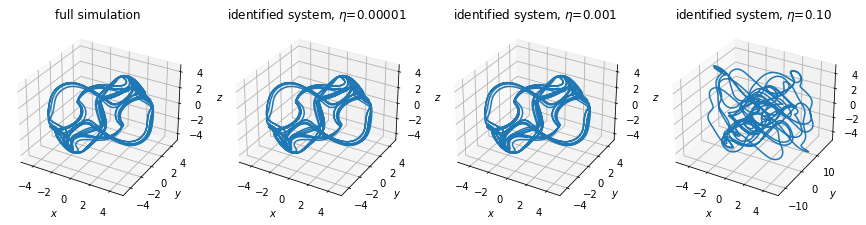

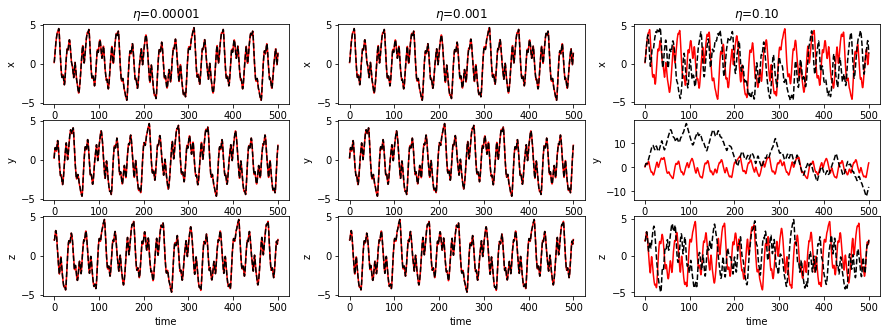

In [10]:
# Plot results

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(141, projection="3d")
ax.plot(
    x_train[: t_sim.size, 0],
    x_train[: t_sim.size, 1],
    x_train[: t_sim.size, 2],
)
plt.title("full simulation")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

model_idx = 0
ax = fig.add_subplot(142, projection="3d")
ax.plot(x_sim_noD[model_idx][:, 0], x_sim_noD[model_idx][:, 1], x_sim_noD[model_idx][:, 2])
plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.5f}")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

model_idx = 2
ax = fig.add_subplot(143, projection="3d")
ax.plot(x_sim_noD[model_idx][:, 0], x_sim_noD[model_idx][:, 1], x_sim_noD[model_idx][:, 2])
plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.3f}")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

model_idx = 4
ax = fig.add_subplot(144, projection="3d")
ax.plot(x_sim_noD[model_idx][:, 0], x_sim_noD[model_idx][:, 1], x_sim_noD[model_idx][:, 2])
plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.2f}")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

fig = plt.figure(figsize=(15, 5))
model_idx = 0
ax = fig.add_subplot(331)
ax.plot(t_sim, x_train[: t_sim.size, 0], "r")
ax.plot(t_sim, x_sim_noD[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.5f}")
plt.ylabel("x")

ax = fig.add_subplot(334)
ax.plot(t_sim, x_train[: t_sim.size, 1], "r")
ax.plot(t_sim, x_sim_noD[model_idx][:, 1], "k--")
plt.xlabel("time")
plt.ylabel("y")

ax = fig.add_subplot(337)
ax.plot(t_sim, x_train[: t_sim.size, 2], "r")
ax.plot(t_sim, x_sim_noD[model_idx][:, 2], "k--")
plt.xlabel("time")
plt.ylabel("z")

model_idx = 2
ax = fig.add_subplot(332)
ax.plot(t_sim, x_train[: t_sim.size, 0], "r")
ax.plot(t_sim, x_sim_noD[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.3f}")
plt.ylabel("x")

ax = fig.add_subplot(335)
ax.plot(t_sim, x_train[: t_sim.size, 1], "r")
ax.plot(t_sim, x_sim_noD[model_idx][:, 1], "k--")
plt.xlabel("time")
plt.ylabel("y")

ax = fig.add_subplot(338)
ax.plot(t_sim, x_train[: t_sim.size, 2], "r")
ax.plot(t_sim, x_sim_noD[model_idx][:, 2], "k--")
plt.xlabel("time")
plt.ylabel("z")

model_idx = 4
ax = fig.add_subplot(333)
ax.plot(t_sim, x_train[: t_sim.size, 0], "r")
ax.plot(t_sim, x_sim_noD[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.2f}")
plt.ylabel("x")

ax = fig.add_subplot(336)
ax.plot(t_sim, x_train[: t_sim.size, 1], "r")
ax.plot(t_sim, x_sim_noD[model_idx][:, 1], "k--")
plt.xlabel("time")
plt.ylabel("y")

ax = fig.add_subplot(339)
ax.plot(t_sim, x_train[: t_sim.size, 2], "r")
ax.plot(t_sim, x_sim_noD[model_idx][:, 2], "k--")
plt.xlabel("time")
plt.ylabel("z")

fig.show()

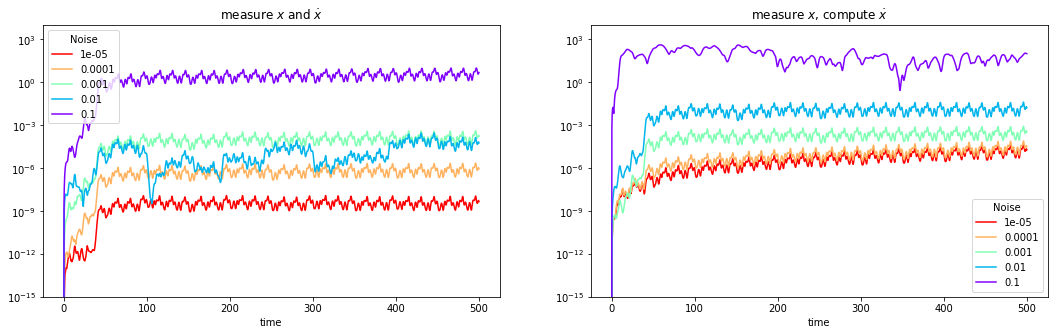

In [14]:
colors = rainbow(np.linspace(1, 0, len(models)))

fig, axs = plt.subplots(1, 2, figsize=(18, 5))
for i, x in enumerate(x_sim):
    axs[0].semilogy(
        t_sim,
        np.sum((x - x_train[: t_sim.size]) ** 2, axis=1),
        color=colors[i],
        label=noise_levels[i],
    )
axs[0].set(xlabel="time", title="measure $x$ and $\dot{x}$")
axs[0].legend(title="Noise")
axs[0].set_ylim(1e-15, 1e4)

for i, x in enumerate(x_sim_noD):
    axs[1].semilogy(
        t_sim,
        np.sum((x - x_train[: t_sim.size]) ** 2, axis=1),
        color=colors[i],
        label=noise_levels[i],
    )

axs[1].set(xlabel="time", title="measure $x$, compute $\dot{x}$")
axs[1].legend(title="Noise")
axs[1].set_ylim(1e-15, 1e4)

fig.show()